## Results of Host Prediction
### Dataset: EMBL mapping, Vertebrates, Non-IDV

**Models**: LR, RF, SVM, XGBoost

**Positional Embedding**: Sin-Cos

**Maximum Sequence Length**: 1036

**Classification**: Multi-class

**\# classes**: 5

**\# train samples** = 

**\# validation samples** = 

**\# test samples** = 

In [1]:
import seaborn

In [4]:
import sys
import os
os.chdir("/home/sipek/zoonosis")
from scipy.stats import mannwhitneyu, wilcoxon, ranksums, iqr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from src.utils import visualization_utils
#from statannotations.Annotator import Annotator
#from statannotations.Annotator import Annotator
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", "..", ".."))
sys.path.append(os.path.join(os.getcwd(), "..", ".."))
sys.path

['/home/sipek/.conda/envs/virprobert/lib/python311.zip',
 '/home/sipek/.conda/envs/virprobert/lib/python3.11',
 '/home/sipek/.conda/envs/virprobert/lib/python3.11/lib-dynload',
 '',
 '/home/sipek/.conda/envs/virprobert/lib/python3.11/site-packages',
 '/home/sipek/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/../../../../..',
 '/home/sipek/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/../../../..',
 '/home/sipek/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/../../..',
 '/home/sipek/zoonosis/src/jupyter_notebooks/results-analysis/uniref90/../..',
 '/home/sipek/zoonosis/../../../../..',
 '/home/sipek/zoonosis/../../../..',
 '/home/sipek/zoonosis/../../..',
 '/home/sipek/zoonosis/../..',
 '/home/sipek/zoonosis/../../../../..',
 '/home/sipek/zoonosis/../../../..',
 '/home/sipek/zoonosis/../../..',
 '/home/sipek/zoonosis/../..']

In [5]:
sns.__version__

'0.11.2'

In [6]:
itr_col = "itr"
experiment_col = "experiment"
y_true_col = "y_true"
human_col = "Human"
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['figure.autolayout'] = True

DEFAULT_FIGURE_CONFIG = {
    "figsize": (10, 10),
    "xtick.labelsize": 18,
    "ytick.labelsize": 18    
}




In [6]:
df = pd.read_csv(os.path.join(os.getcwd(), "..",  "..", "..", "..", "output/evaluation/uniref90/20250206/host_multi/host_multi_all_models_evaluation_metrics.csv"))
df.drop(columns="Unnamed: 0", inplace=True)
df

,itr,experiment,auprc
0,0,LR,0.433765
1,1,LR,0.428972
2,2,LR,0.440230
3,3,LR,0.464170
4,4,LR,0.437962
...,...,...,...
74,0,VirProBERT,0.639349
75,1,VirProBERT,0.672554
76,2,VirProBERT,0.703604
77,3,VirProBERT,0.688975


In [7]:
df = df.replace({"experiment": {"LR-maxitr5000": "LR", "Protein-BERT": "ProteinBERT", "VirPro-BERT": "VirProBERT", "Protein-BERT_new_ds": "ProteinBERT", "ProtT5-xl-uniref50": "ProtT5", "ProstT5-lr3e-4-new": "ProstT5"}})

In [8]:
df["experiment"].unique()

array(['LR', 'RF', 'SVM', 'FNN', 'CNN', 'RNN', 'LSTM',
       'Transformer-Encoder', 'ProtT5', 'ProstT5-lr3e-4-old', 'ProstT5',
       'ESM2-t12_35M_UR50D', 'ESM2-t33_650M_UR50D', 'ESM2-t36_3B_UR50D',
       'ESM3', 'VirProBERT'], dtype=object)

In [9]:
sub_df = df[df["experiment"].isin(["LR", "RF", "SVM", "CNN", "RNN", "LSTM", "ProtT5", "ProstT5", 'ESM3', "VirProBERT"])]
sub_df = sub_df.replace({"experiment": {"Hybd-sl256st64-CLS-vs30-AE-BN": "VirProBERT"}})

In [10]:
sub_df["experiment"].unique()

array(['LR', 'RF', 'SVM', 'CNN', 'RNN', 'LSTM', 'ProtT5', 'ProstT5',
       'ESM3', 'VirProBERT'], dtype=object)

In [52]:
experiments = ['LR', 'RF', 'SVM', 'CNN', 'RNN', 'LSTM', 'ProtT5', 'ProstT5',
       'ESM3', 'VirProBERT']
pairs = [#("ProteinBERT", "VirProBERT"),
         #("VirProBERT", "Transformer-Encoder"), 
         ("VirProBERT", "ESM3"), 
         ("VirProBERT", "ProstT5"),
         ("VirProBERT", "ProtT5"),
         ("VirProBERT", "LSTM"),
         ("VirProBERT", "RNN"),
         ("VirProBERT", "CNN")]

def get_p_value_annotation(p_value):
    if p_value > 5e-2 and p_value <= 1:
        return "ns"
    elif p_value > 1e-2 and p_value <= 5e-2:
        return "*"
    elif p_value > 1e-3 and p_value <= 1e-2:
        return "**"
    elif p_value > 1e-4 and p_value <= 1e-3:
        return "***"
    elif p_value <= 1e-4:
        return "****"
    else:
        return None
    
def plot_boxplot_w_stat_custom_annotation(df, metric, pairs, location, ylim):
    DEFAULT_FIGURE_CONFIG = {
        "figsize": (14, 6),
        "xtick.labelsize": 18,
        "ytick.labelsize": 18
    }
    color_palette = sns.cubehelix_palette(start=3, rot=4.5, hue=1, gamma=0.9, dark=0.7, light=0.4, reverse=True, n_colors=df["experiment"].nunique())
    plotting_parameters = {
        'data':    df,
        'x':       'experiment',
        'y':       metric,
        "linewidth": 2,
        #"edgecolor": "black",
        "linecolor": "black",
        "legend": False,
        "hue": "experiment",
#         "boxprops": {"edgecolor": "black"},
#         "whiskerprops": {"color": "black"},
#         "flierprops": {"color": "black"},
#         "fliersize": 7.0,
#         "medianprops": {"linewidth": 2.5},
        'palette': color_palette#sns.color_palette("magma", n_colors=len(experiments)),
        #"notch": True,
        #"fill": False
    }
    
    visualization_utils.pre_plot_config(DEFAULT_FIGURE_CONFIG)
    ax = sns.boxplot(**plotting_parameters, order=experiments)
    sns.stripplot(data=df, x="experiment", y=metric, ax=ax, color="black", size=8, alpha=.7, order=experiments)
    ax.set_xlabel("", size=1, labelpad=5)
    ax.set_ylabel(metric.upper(), size=20)
    plt.draw()
    ax.set_ylim(*ylim)
    
    #plt.tight_layout()
    
    for i, pair in enumerate(pairs):
        model_1_values = df[df["experiment"] == pair[0]][metric].values
        model_2_values = df[df["experiment"] == pair[1]][metric].values
        p_value = mannwhitneyu(model_1_values, model_2_values, alternative="two-sided").pvalue
        formatted_pvalue = f"p={p_value:.2e}"
        print(f"{pair}: p-value={formatted_pvalue}")
        
        x_ticks = [t.get_text()  for t in ax.get_xticklabels()]
        x1 = experiments.index(pair[0])
        x2 = experiments.index(pair[1])
        y1 = max(df[df["experiment"] == pair[0]][metric].max(), 
                 df[df["experiment"] == pair[1]][metric].max()) + (0.05 * (i + 1))
        y2 = y1 + .01
        
        plt.plot([x1, x1, x2, x2], [y1, y2, y2, y1], lw=2, c="k")
        plt.text((x1 + x2)*.5, y1, get_p_value_annotation(p_value), ha='center', va='bottom', color="k", size="18")
    visualization_utils.wrap_ticklabels(ax, axis="x", label_width=10, break_long_words=True)
    plt.savefig(os.path.join(os.getcwd(), "..", "..", "..", "..", f"output/visualization/temp_new/host_multi_all_models_{metric}_boxplot_stat.pdf"), bbox_inches="tight")

/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/home/blessyantony/miniconda3/envs/zoonosis/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/blessyantony/miniconda3/envs/zoonosis/lib/python

('VirProBERT', 'ESM3'): p-value=p=5.48e-01
('VirProBERT', 'ProstT5'): p-value=p=3.17e-02
('VirProBERT', 'ProtT5'): p-value=p=1.00e+00
('VirProBERT', 'LSTM'): p-value=p=7.94e-03
('VirProBERT', 'RNN'): p-value=p=7.94e-03
('VirProBERT', 'CNN'): p-value=p=7.94e-03


<Figure size 640x480 with 0 Axes>

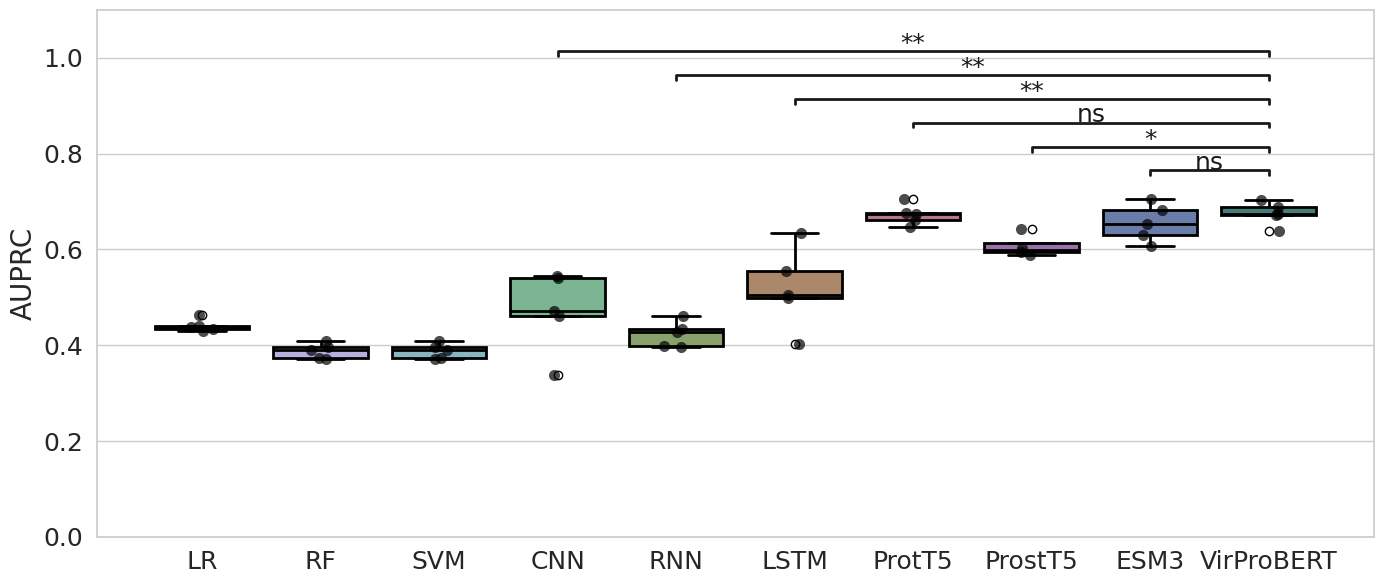

In [53]:
plot_boxplot_w_stat_custom_annotation(sub_df, "auprc", pairs, location="inside", ylim=(0, 1.1))

In [13]:
df

,itr,experiment,auprc
0,0,LR,0.433765
1,1,LR,0.428972
2,2,LR,0.440230
3,3,LR,0.464170
4,4,LR,0.437962
...,...,...,...
74,0,VirProBERT,0.639349
75,1,VirProBERT,0.672554
76,2,VirProBERT,0.703604
77,3,VirProBERT,0.688975


In [14]:
df[["experiment", "auprc"]].groupby("experiment").agg(["mean", "std", "median", iqr])

auprc                              
                         mean       std    median       iqr
experiment                                                 
CNN                  0.471601  0.083857  0.471966  0.079258
ESM2-t12_35M_UR50D   0.687613  0.011723  0.689764  0.012437
ESM2-t33_650M_UR50D  0.718822  0.008105  0.722028  0.012427
ESM2-t36_3B_UR50D    0.712150  0.017103  0.710980  0.019794
ESM3                 0.655855  0.039196  0.653017  0.051689
FNN                  0.569747  0.045961  0.600000  0.047475
LR                   0.441020  0.013635  0.437962  0.006465
LSTM                 0.518839  0.084445  0.504004  0.055927
ProstT5              0.607420  0.024561  0.599023  0.019120
ProstT5-lr3e-4-old   0.596748  0.020187  0.592882  0.022586
ProtT5               0.672491  0.021348  0.673640  0.013354
RF                   0.388085  0.015864  0.389473  0.022648
RNN                  0.423322  0.027061  0.428531  0.035506
SVM                  0.388085  0.015864  0.389473  0.022648
Transformer-Encoder  0.559360  0.021680  0.553689  0.006748
VirProBERT           0.675713  0.023920  0.674083  0.016421